In [1]:
#https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from net import MobileNetV2

In [2]:
import sys
sys.path.append('src-pytorch')

In [4]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [5]:
model = MobileNetV2(pretrained=True)
# model = model.float()
model.eval()

In [8]:
img, _ = next(iter(dataloader))

In [9]:
img.shape

torch.Size([1, 3, 224, 224])

In [10]:
model(img)

tensor([[ 0.5656, -0.2349]], grad_fn=<AddmmBackward>)

In [11]:
pred = model(img)

In [12]:
pred

tensor([[ 0.5656, -0.2349]], grad_fn=<AddmmBackward>)

In [13]:
pred[:,0].backward()

In [14]:
gradients = model.get_activations_gradient()

In [15]:
gradients.shape

torch.Size([1, 1280, 7, 7])

In [16]:
img.shape

torch.Size([1, 3, 224, 224])

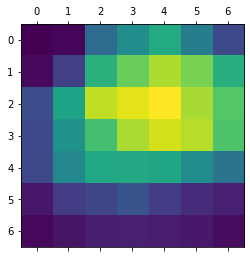

In [17]:
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [23]:
import cv2
img = cv2.imread('./data/ele/ele.jpeg')
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True